# A simpl(er) Introduction to Hierarchical Models 
### Naive Bayesians, 2021


### Agenda

1. Univariate Model (Radon Gas)
    * Pooled 
    * Unpooled 
    * Hierarchical 

2. Multivariate model (Synthetic Data)
    * Pooled 
    * Unpooled 
    * Hierarchical 

#### Notebook Setup

In [1]:
%load_ext nb_black
%reload_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:85% !important; }</style>"))

<IPython.core.display.Javascript object>

In [2]:
import os
from scipy import stats
import pandas as pd
import numpy as np
from typing import Dict

# ML libraries
import pymc3 as pm
from sklearn.linear_model import LinearRegression

# Plotting and viz
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["font.size"] = 15

<IPython.core.display.Javascript object>

## Univariate Regression - Radon Gas Example

Suppose the radon concentration for a specific house, $i$, in county, $c$ is related to if the house has a basement with the relationship:  

$$
\begin{align*}
\text{Pooled:  } \text{log_radon}_{i, c} = {} & \alpha + \beta \hspace{1mm} \text{floor}_{i, c} + \epsilon_{i, c}, \\
\text{Unpooled:  }  \text{log_radon}_{i, c} = {} & \alpha_{c} + \beta_{c} \hspace{1mm} \text{floor}_{i, c} + \epsilon_{i, c}
\end{align*}
$$

where $\alpha_{c}$ is the average radon concentration, $\text{floor}_{i, c}  = 0$ if the house has a basement  $\text{floor}_{i, c}  = 1$ if the house doesn't have a basement. 

In [3]:
# Load data
def load_radon_data() -> pd.DataFrame:
    data = pd.read_csv(pm.get_data("radon.csv"))
    data = data[["county", "floor", "log_radon"]]
    return data


radon_data = load_radon_data()

counties = radon_data["county"].drop_duplicates().to_list()

print(f"Num counties: {len(counties)}")

# Map each county with an index
county_index_mapping = {county: index for index, county in enumerate(counties)}

radon_data = radon_data.assign(
    **{"county_index": lambda x: x["county"].map(county_index_mapping)}
)
display(radon_data)

Num counties: 85


,county,floor,log_radon,county_index
0,AITKIN,1.0,0.832909,0
1,AITKIN,0.0,0.832909,0
2,AITKIN,0.0,1.098612,0
3,AITKIN,0.0,0.095310,0
4,ANOKA,0.0,1.163151,1
...,...,...,...,...
914,WRIGHT,0.0,1.871802,83
915,WRIGHT,0.0,1.526056,83
916,WRIGHT,0.0,1.629241,83
917,YELLOW MEDICINE,0.0,1.335001,84


<IPython.core.display.Javascript object>

### 1. Pooled Model Radon Gas Example

In [4]:
# Build individual models
with pm.Model() as ind_radon_model:
    # Prior
    # ---> Regression Coefficients
    alpha = pm.Normal("alpha", mu=0, sigma=10, shape=1)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=1)
    # ---> Noise
    eps = pm.HalfCauchy("eps", 5)

    # Likelihood
    mu = alpha + beta * radon_data["floor"]
    y = pm.Normal("obs", mu=mu, sigma=eps, observed=radon_data["log_radon"])

    # Posterior
    trace = pm.sample(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 35 seconds.


<IPython.core.display.Javascript object>

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


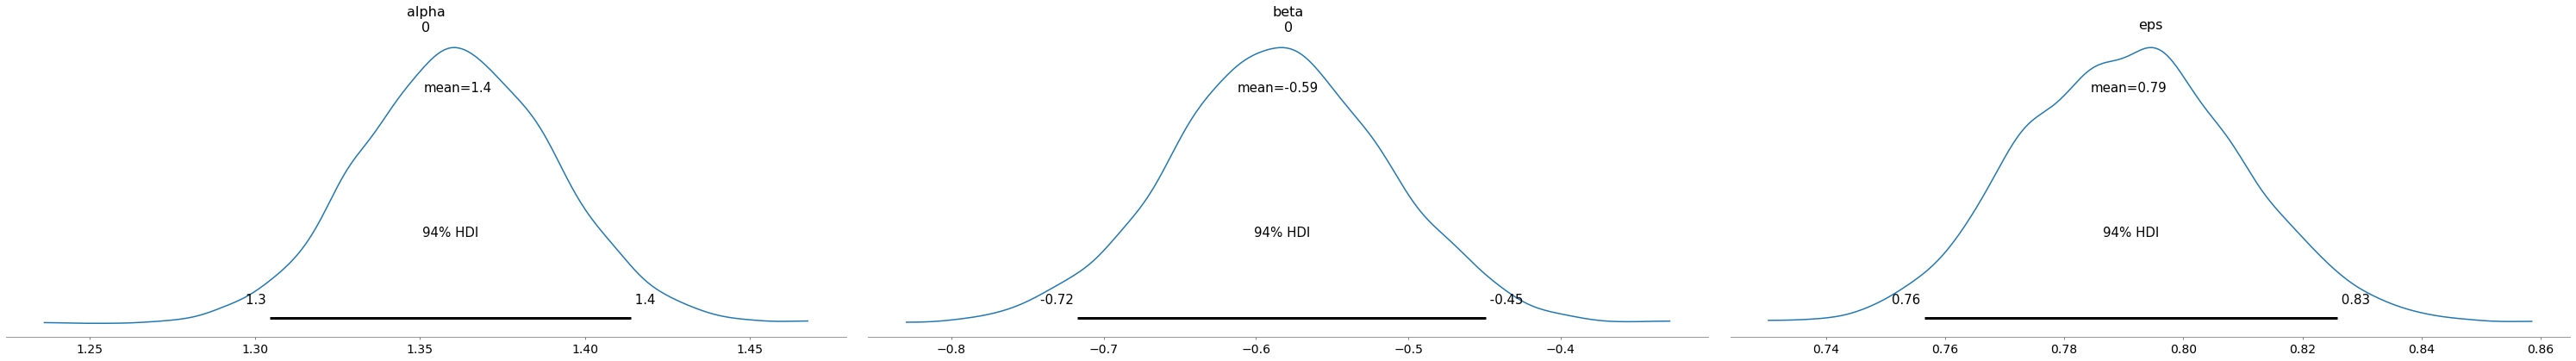

<IPython.core.display.Javascript object>

In [6]:
pm.plot_posterior(trace)
plt.show()

In [7]:
with ind_radon_model:
    display(pm.summary(trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],1.361,0.029,1.304,1.414,0.000,0.000,3920.0,3920.0,3936.0,2972.0,1.0
beta[0],-0.586,0.071,-0.717,-0.449,0.001,0.001,3666.0,3666.0,3665.0,2404.0,1.0
eps,0.791,0.019,0.757,0.826,0.000,0.000,4999.0,4999.0,4978.0,2781.0,1.0


<IPython.core.display.Javascript object>

### 2. Unpooled Model Radon Gas Example

In [16]:
# Build individual models
with pm.Model() as unpooled_radon_model:
    # Prior
    # ---> Regression Coefficients
    alpha = pm.Normal("alpha", mu=0, sigma=10, shape=len(counties))
    beta = pm.Normal("beta", mu=0, sigma=10, shape=len(counties))
    # ---> Noise
    eps = pm.HalfCauchy("eps", 5)

    # Likelihood
    mu = (
        alpha[radon_data["county_index"]]
        + beta[radon_data["county_index"]] * radon_data["floor"]
    )
    y = pm.Normal("obs", mu=mu, sigma=eps, observed=radon_data["log_radon"])

    # Posterior
    trace = pm.sample(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 103 seconds.
/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


<IPython.core.display.Javascript object>

In [17]:
with unpooled_radon_model:
    display(pm.summary(trace))

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.680,0.413,-0.114,1.435,0.005,0.004,7820.0,5106.0,7800.0,3383.0,1.0
alpha[1],0.953,0.102,0.762,1.146,0.001,0.001,7938.0,7938.0,7934.0,3126.0,1.0
alpha[2],1.475,0.719,0.123,2.814,0.009,0.007,6216.0,4794.0,6220.0,3022.0,1.0
alpha[3],1.710,0.421,0.928,2.493,0.005,0.004,7845.0,7021.0,7834.0,2947.0,1.0
alpha[4],1.339,0.410,0.580,2.114,0.005,0.003,8124.0,7588.0,7586.0,3296.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
beta[81],-0.035,9.778,-18.059,18.569,0.107,0.188,8320.0,1358.0,8324.0,2738.0,1.0
beta[82],-1.981,0.471,-2.854,-1.093,0.006,0.004,7010.0,6737.0,7027.0,3246.0,1.0
beta[83],-0.788,0.773,-2.186,0.664,0.008,0.008,9434.0,4143.0,9485.0,2976.0,1.0
beta[84],0.152,9.896,-18.332,18.848,0.107,0.176,8625.0,1578.0,8616.0,2958.0,1.0


<IPython.core.display.Javascript object>

### 3. Hierarchical Model Radon Gas Example

In [18]:
# Build individual models
with pm.Model() as hierarchical_radon_model:
    # Prior
    # -> Global prior
    mu_alpha_glob = pm.Normal("mu_alpha", mu=0, sigma=10)
    sigma_alpha_glob = pm.HalfCauchy("sig_alpha", 5)

    mu_beta_glob = pm.Normal("mu_beta", mu=0, sigma=10)
    sigma_beta_glob = pm.HalfCauchy("sig_beta", 5)

    # ---> Regression Coefficients
    alpha = pm.Normal(
        "alpha", mu=mu_alpha_glob, sigma=sigma_alpha_glob, shape=len(counties)
    )
    beta = pm.Normal(
        "beta", mu=mu_beta_glob, sigma=sigma_beta_glob, shape=len(counties)
    )
    # ---> Noise
    eps = pm.HalfCauchy("eps", 5)

    # Likelihood
    mu = (
        alpha[radon_data["county_index"]]
        + beta[radon_data["county_index"]] * radon_data["floor"]
    )
    y = pm.Normal("obs", mu=mu, sigma=eps, observed=radon_data["log_radon"])

    # Posterior
    trace = pm.sample(draws=2000)

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha, sig_beta, mu_beta, sig_alpha, mu_alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 118 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

In [19]:
with hierarchical_radon_model:
    display(pm.summary(trace))

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_alpha,1.492,0.052,1.397,1.588,0.001,0.001,1498.0,1493.0,1497.0,2643.0,1.00
mu_beta,-0.648,0.083,-0.803,-0.500,0.004,0.003,495.0,495.0,496.0,1328.0,1.00
alpha[0],1.204,0.250,0.711,1.658,0.004,0.003,3855.0,3783.0,3864.0,2576.0,1.00
alpha[1],0.989,0.095,0.809,1.158,0.002,0.001,3640.0,3481.0,3622.0,2359.0,1.00
alpha[2],1.500,0.273,1.000,2.016,0.004,0.003,3833.0,3663.0,3814.0,2306.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
beta[83],-0.663,0.285,-1.187,-0.095,0.005,0.004,3463.0,3142.0,3490.0,2096.0,1.00
beta[84],-0.652,0.317,-1.218,-0.015,0.005,0.004,3718.0,2628.0,3776.0,2025.0,1.00
sig_alpha,0.326,0.047,0.245,0.419,0.001,0.001,1062.0,1062.0,1049.0,2056.0,1.00
sig_beta,0.295,0.104,0.098,0.473,0.008,0.006,175.0,175.0,167.0,217.0,1.01


<IPython.core.display.Javascript object>

## Multivariate Model - Synthetic Example

### Data Model

Suppose you have data from 2 different sites. 
\begin{align*}
y_{a, i} =  \pmb{w}_{a}^\textsf{T}\pmb{x}_{a, i} + \epsilon_{i}  \;\;\;\;
y_{b, i} = \pmb{w}_{b}^\textsf{T}\pmb{x}_{b, i} + \epsilon_{i} \\
\end{align*}



The data can be collected into a observation vector as follows:
\begin{align*}
\pmb{y} = {} & \begin{bmatrix} \pmb{y}_{a} \\   \pmb{y}_{b} \end{bmatrix} \;\;\;\;
\end{align*}

where, the observations from the indiviual sites as
\begin{align*}
\pmb{y}_{a} = {} & \begin{bmatrix}y_{a, 1} \\ \vdots \\  y_{a, N_{a}}  \end{bmatrix}  \;\;\;\;
\pmb{y}_{b} =  \begin{bmatrix}y_{b, 1} \\ \vdots \\  y_{b, N_{b}}  \end{bmatrix} \\
\end{align*}

#### Vectorised representation

So the observations can be expressed as: 

\begin{align*}
\pmb{y}_{a} = {} & \pmb{X}_{a}\pmb{w}_{a} + \pmb{\epsilon} \;\;\;\;
\pmb{y}_{b} =   \pmb{X}_{b}\pmb{w}_{b} + \pmb{\epsilon}  \\
\end{align*}

The regressors (or inputs), $\pmb{x}$ can be collected into a matrix 
\begin{align*}
\pmb{X}_{a}= {} & \begin{bmatrix} \pmb{x}^\textsf{T}_{a, 1} \\ \vdots \\  \pmb{x}^\textsf{T}_{a, N_{a}}  \end{bmatrix} \;\;\;\;
\pmb{X}_{b}=  \begin{bmatrix} \pmb{x}^\textsf{T}_{b, 1} \\ \vdots \\  \pmb{x}^\textsf{T}_{b, N_{b}}  \end{bmatrix} \\
\end{align*}

and the data from the 2 sites, $a$ and $b$ can be augmented as, 
$
\begin{align*}
\pmb{X} = {} & \begin{bmatrix} \pmb{X}_{a} \\   \pmb{X}_{b} \end{bmatrix}.
\end{align*}
$

In [20]:
n = 1000
w_opt_a = np.array([1, 3.5, 6])
w_opt_b = np.array([-1, -3.5, -6])
m = len(w_opt_a)

X = stats.norm.rvs(size=(n * 2, m), loc=0, scale=1)

X_a, X_b = X[0:n], X[n:]


y = np.append((X_a @ w_opt_a), (X_b @ w_opt_b)) + stats.norm.rvs(
    size=n * 2, loc=0, scale=0.5
)

<IPython.core.display.Javascript object>

### 1. Pooled Model 

The pooled model considers both the data set (Least squares solution)

\begin{align*}
\hat{\pmb{w}}_{\textsf{pooled}} = {} & \left(\pmb{X}^\textsf{T} \pmb{X} \right)^{-1} \pmb{X}^\textsf{T}\pmb{y}
\end{align*}

In [21]:
w = np.linalg.inv((X.T @ X)) @ (X.T @ y)
print("Direct computation", w)

lin_mod = LinearRegression(fit_intercept=False)
lin_mod.fit(X, y)
print("Sklearn Linear Regession", lin_mod.coef_)

Direct computation [-0.18961844  0.14853917 -0.07994343]
Sklearn Linear Regession [-0.18961844  0.14853917 -0.07994343]


<IPython.core.display.Javascript object>

#### Pooled Model (Bayesian)

In [22]:
with pm.Model() as mod:
    w_ = pm.Normal(name="w", mu=0, sigma=10, shape=m)
    sigma = pm.InverseGamma("sigma", mu=1, sigma=10)
    obs = pm.Normal(name="obs", observed=y, mu=X @ w_, sigma=sigma)
    trace = pm.sample(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, w]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 36 seconds.


<IPython.core.display.Javascript object>

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


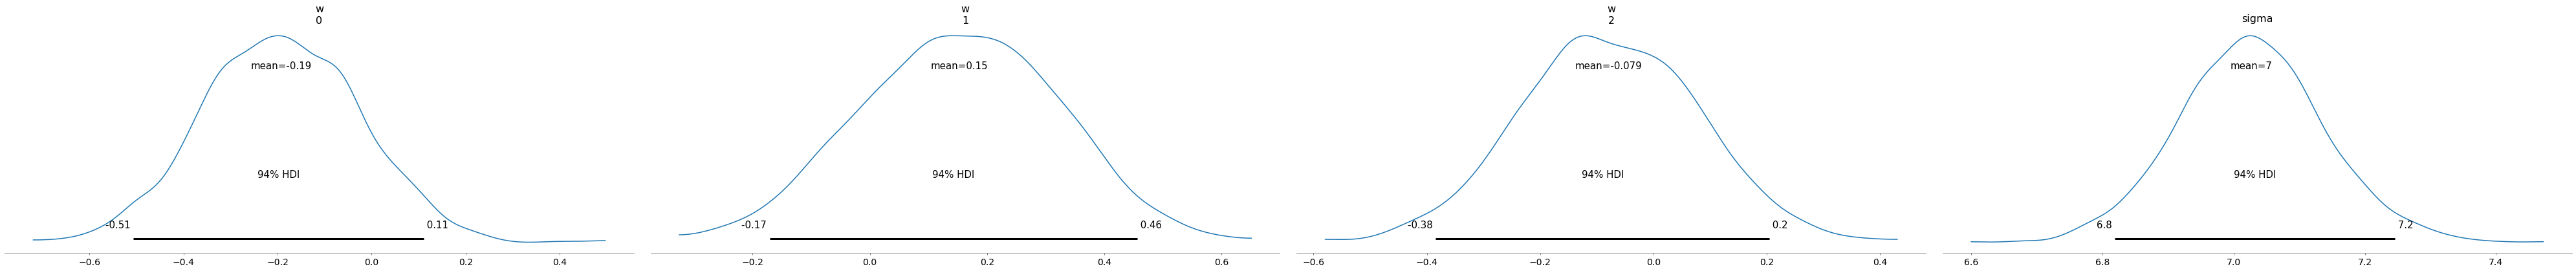

<IPython.core.display.Javascript object>

In [23]:
pm.plot_posterior(trace)
plt.show()

### 2. Unpooled Model 

#### Representation  

Since, we'd like to estimate the individual parameters from site $a$ & $b$, the 2 vectors can be augmented as
$
\begin{align*}
\hat{\pmb{w}} =  \begin{bmatrix}  \hat{\pmb{w}}_a  ,   \hat{\pmb{w}}_b\end{bmatrix} 
\end{align*}
$ to give us a $(M \times 2)$ matrix

As seen before the regressors can be augmened into a $(N_a + N_b) \times m$ matrix,
$
\begin{align*}
\pmb{X} = {} & \begin{bmatrix} \pmb{X}_{a} \\   \pmb{X}_{b} \end{bmatrix}. 
\end{align*}
$

To get to our observations, we first multiple the regressors and the regression coefficients as follows

\begin{align*}
\tilde{\pmb{y}} = {} & \pmb{X} \hat{\pmb{w}}   \\
 = {} & \begin{bmatrix} \pmb{X}_{a} \\   \pmb{X}_{b} \end{bmatrix} \begin{bmatrix}  \hat{\pmb{w}}_a  ,   \hat{\pmb{w}}_b\end{bmatrix} \\
  = {} & \begin{bmatrix} \hat{\pmb{y}}_{a}, \ \tilde{\pmb{y}}_{ab} \\  \tilde{\pmb{y}}_{ba}, \hat{\pmb{y}}_{b} \end{bmatrix} 
\end{align*}

This gives us an augmented observation matrix of size $(N_a + N_b) \times 2$. Recall that our observations are a _vector_ of the size $(N_a + N_b) \times 1$, i.e.

\begin{align*}
\hat{\pmb{y}} = {} & \begin{bmatrix} \hat{\pmb{y}}_{a} \\ \hat{\pmb{y}}_{b} \end{bmatrix} 
\end{align*}

So, to extract a the observation vector $\hat{\pmb{y}}$ from the augmented matrix $\tilde{\pmb{y}}$, we need to access the 
correct elements: 
\begin{align*}
\hat{\pmb{y}} = {} & \tilde{\pmb{y}}\textsf{.iloc}\left( \begin{bmatrix} 0 & 0 \\ 1 & 0 \\ \vdots & 0 \\ N_a & 0 \\ N_a + 1 & 1 \\ N_a + 2 & 1 \\ \vdots & 1 \\ N_a + N_b & 1 \end{bmatrix}  \right)
\end{align*}



In [24]:
index_cols = tuple(
    np.append(np.zeros(len(X_a), dtype=np.int8), np.ones(len(X_b), dtype=np.int8))
)
index_rows = tuple(np.arange(len(X_a) + len(X_b)))

with pm.Model() as ind_mod:
    # Prior
    # -> Individial priors
    w_ind = pm.Normal(name="w", mu=0, sigma=10, shape=(m, 2))
    sigma = pm.InverseGamma("sigma", mu=1, sigma=10)

    # Likelihood
    mu = (X @ w_ind)[index_rows, index_cols]
    obs = pm.Normal(name="obs", observed=y, mu=mu, sigma=sigma)

    # Sample from the posterior
    trace = pm.sample(draws=1500)

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, w]


Sampling 2 chains for 1_000 tune and 1_500 draw iterations (2_000 + 3_000 draws total) took 54 seconds.
/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


<IPython.core.display.Javascript object>

In [25]:
trace.get_values(varname="w").shape

(3000, 3, 2)

<IPython.core.display.Javascript object>

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


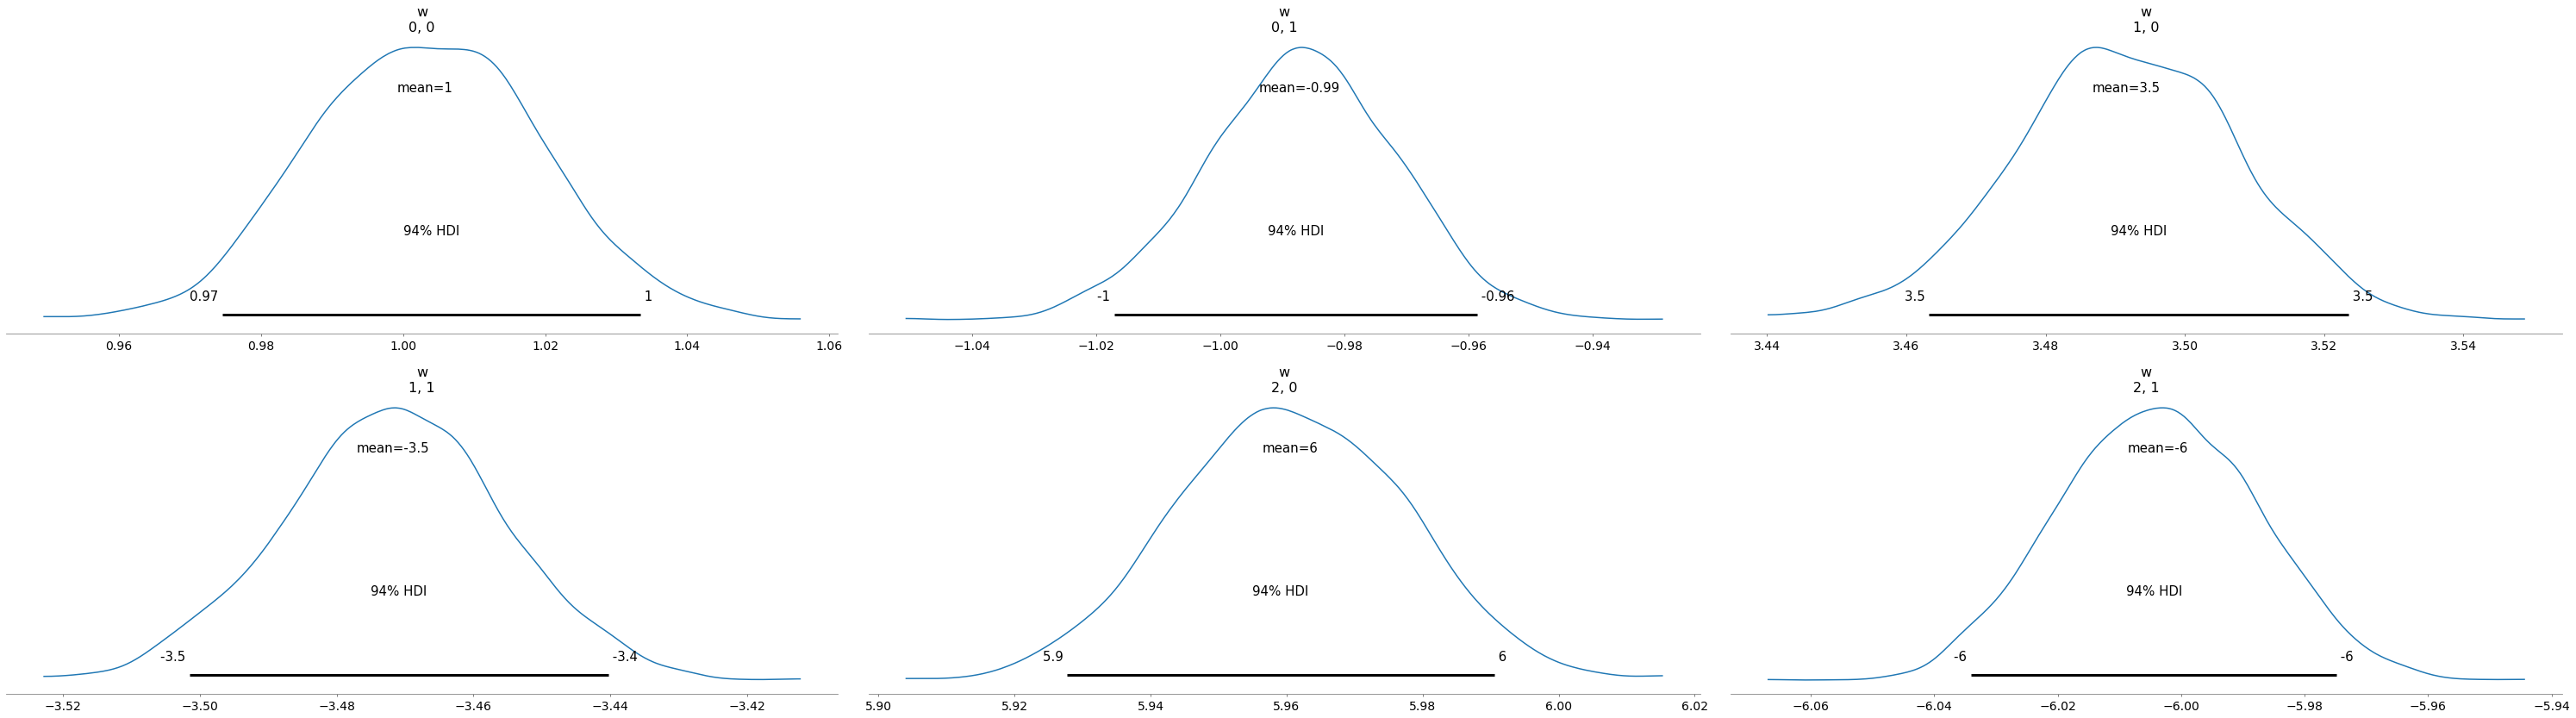

<IPython.core.display.Javascript object>

In [26]:
pm.plot_posterior(trace, var_names=["w"])
plt.show()

In [27]:
with ind_mod:
    display(pm.summary(trace))

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"w[0,0]",1.003,0.016,0.975,1.033,0.0,0.0,5019.0,5019.0,4981.0,2249.0,1.0
"w[0,1]",-0.987,0.016,-1.017,-0.959,0.0,0.0,5383.0,5377.0,5391.0,2381.0,1.0
"w[1,0]",3.492,0.016,3.463,3.524,0.0,0.0,5000.0,5000.0,5013.0,2216.0,1.0
"w[1,1]",-3.472,0.016,-3.502,-3.440,0.0,0.0,5018.0,5016.0,5001.0,2245.0,1.0
"w[2,0]",5.960,0.017,5.928,5.990,0.0,0.0,5801.0,5801.0,5801.0,2165.0,1.0
"w[2,1]",-6.004,0.016,-6.034,-5.975,0.0,0.0,6355.0,6351.0,6301.0,2566.0,1.0
sigma,0.509,0.008,0.494,0.524,0.0,0.0,5640.0,5640.0,5627.0,2238.0,1.0


<IPython.core.display.Javascript object>

### 3. Hierarchical Model 

In [ ]:
with pm.Model() as hierarchical_mod:
    # Prior

    # -> Global Prior
    mu_w_glob = pm.Normal(name="mu_w", mu=0, sigma=10, shape=(m, 1))
    sigma_w_glob = pm.InverseGamma("sigma_w", mu=1, sigma=10)

    # -> Individial priors
    w_hierarchy = pm.Normal(name="w", mu=mu_w_glob, sigma=sigma_w_glob, shape=(m, 2))
    sigma = pm.InverseGamma("sigma", mu=1, sigma=10)

    # Likelihood
    mu = (X @ w_hierarchy)[index_rows, index_cols]
    obs = pm.Normal(name="obs", observed=y, mu=mu, sigma=sigma)

    # Sample from the posterior
    trace = pm.sample(draws=1500)

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, w, sigma_w, mu_w]


In [ ]:
with hierarchical_mod:
    display(pm.summary(trace))